### Тематическое моделирование 



Построим тематические модели для корпуса новостей Lenta.ru, с которым мы уже работали ранее.

In [60]:
import pandas as pd

In [61]:
data = pd.read_csv('lenta-ru-news.csv')

In [62]:
data.sample(3)

,url,title,text,topic,tags
332879,https://lenta.ru/news/2012/01/30/fakecheck/,Экс-сотрудник Apple рассказал о разработках ненужных продуктов,"Некоторым новым сотрудникам Apple в первые месяцы в компании поручается работа над продуктами, которые заведомо не поступят в производство. ""Настоящие"" задания даются им только после того, как руководство убедится в их благонадежности. О такой практике рассказал один из бывших сотрудников компании, передает Business Insider. Сотрудник сообщил, что его друг начал свою карьеру в Apple с того, что разрабатывал ""вымышленные"" устройства. Кроме того, на протяжении девяти месяцев ему приходилось регулярно проходить собеседования. Сейчас этот человек занимает в Apple должность ведущего инженера. Рассказ о политике Apple в отношении новых сотрудников прозвучал в ходе пресс-конференции Адама Лашински (Adam Lashinsky), автора книги ""Внутри Apple"" (Inside Apple). Конференция состоялась в штаб-квартире соцсети LinkedIn. Фрагмент видеозаписи, сделанной на мероприятии, можно посмотреть здесь. Лашински, старший редактор журнала Fortune, в своей книге описал внутреннюю организацию Apple. Он утверждает, что о том, как будет выглядеть итоговый продукт, знают, как правило, лишь избранные сотрудники компании. Большинство работников, как и рядовые пользователи, впервые видят новое устройство только во время его презентации. Стив Джобс, возглавлявший Apple до 2011 года, на каждом совещании напоминал собравшимся, что допустивший утечку информации будет уволен из компании и подвергнут юридическому преследованию, говорится в книге. Джобс передал пост гендиректора Apple Тиму Куку в августе 2011 года, примерно за полтора месяца до смерти. Несмотря на повышенные меры безопасности, бывали случаи, когда информация о готовящихся продуктах Apple досрочно попадала в СМИ. Наиболее громким стал скандал, разразившийся в 2010 году. Тогда сотрудник Apple Грей Пауэлл (Gray Powell) забыл в баре прототип iPhone 4. Через посредника смартфон попал в руки журналистов блога Gizmodo, которые разместили фотографии устройства в интернете.",Наука и техника,Все
286069,https://lenta.ru/news/2013/02/01/elections/,В Армении допустили перенос выборов из-за покушения на кандидата,"Президентские выборы в Армении, запланированные на 18 февраля, могут быть отложены из-за покушения на жизнь одного из кандидатов — Паруйра Айрикяна. Об этом, как сообщает REGNUM, заявил спикер парламента республики Овик Абрамян. «По крайней мере, возможность переноса выборов предусмотрена законодательством, если Паруйр Арикян не сможет продолжить предвыборную гонку», — отметил председатель парламента. Как сообщалось ранее, в ночь на 1 февраля было совершено покушение на кандидата в президенты, лидера объединения «Национальное самоопределение» Паруйра Айрикяна. Неизвестный дважды выстрелил в него, а затем скрылся. Пострадавший был госпитализирован. Врачи оценивают его состояние как среднетяжелое. Жизни Айрикана, как утверждается, эти ранения не угрожают. Пострадавший находится в сознании. Пострадавшего кандидата посетили глава правительства Армении Тигран Саргсян, спикер парламента Овик Абрамян и другие высокопоставленные чиновники. Председатель парламента, говоря о покушении, расценил его как выпад против армянской государственности. Как передает Panorama.am, он также назвал произошедшее попыткой дестабилизировать ситуацию в стране. В свою очередь, министр образования республики Армен Ашотян, как сообщает «Новости-Армения», заявил, что покушение было совершено с целью сорвать выборы. Сегодня, 1 февраля, пострадавшего, как передает Armenia Today, прооперируют, чтобы извлечь пулю, попавшую ему в правое плечо. В связи с произошедшим возбуждено уголовное дело по статье «Попытка убийства государственного, политического или общественного деятеля, которая совершена с целью прекращения его деятельности». Следствие ведет Служба национальной безопасности. Паруйр Айрикян — один из восьми кандидатов в президенты на нынешних выборах. В советские времена он был диссидентом.

In [63]:
data.topic.value_counts().head(20)

Россия               160519
Мир                  136680
Экономика            79538 
Спорт                64421 
Культура             53803 
Бывший СССР          53402 
Наука и техника      53136 
Интернет и СМИ       44675 
Из жизни             27611 
Дом                  21734 
Силовые структуры    19596 
Ценности             7766  
Бизнес               7399  
Путешествия          6408  
69-я параллель       1268  
Крым                 666   
Культпросвет         340   
Легпром              114   
Библиотека           65    
Оружие               3     
Name: topic, dtype: int64

In [64]:
topics = ['Россия', 'Мир', 'Экономика']

data = data[data.topic.isin(topics)]
data.dropna(inplace=True)
len(data)

368190

### Предобработка


Все модели, с которыми мы будем работать далее, работают с предобработанными текстами, поэтому сперва проведем стандартную предобработку текста:

In [65]:
import re
import numpy as np
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
from multiprocessing import Pool
from pymystem3 import Mystem

In [66]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/anna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [67]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

/Users/anna/miniforge3/envs/tf_m1/lib/python3.8/site-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/Users/anna/miniforge3/envs/tf_m1/lib/python3.8/site-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/Users/anna/miniforge3/envs/tf_m1/lib/python3.8/site-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/Users/anna/miniforge3/envs/tf_m1/lib/python3.8/site-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, 

In [68]:
words_regex = re.compile('\w+')

def find_words(text, regex = words_regex):
    tokens =  regex.findall(text.lower())
    return [w for w in tokens if w.isalpha() and len(w) >= 3]


stopwords_list = stopwords.words('russian')

# mystem = Mystem()
# def lemmatize(words, lemmer = mystem, stopwords = stopwords_list):
#     lemmas = lemmer.lemmatize(' '.join(words))
#     return [w for w in lemmas if not w in stopwords 
#             and w.isalpha()]

def lemmatize(words, lemmer = morph, stopwords = stopwords_list):
    lemmas = [lemmer.parse(w)[0].normal_form for w in words]
    return [w for w in lemmas if not w in stopwords 
            and w.isalpha()]

def preprocess(text):
    return (lemmatize(find_words(text)))

<>:1: DeprecationWarning: invalid escape sequence \w
<>:1: DeprecationWarning: invalid escape sequence \w
/var/folders/9q/dsjswm2x2q9_rxvxgvcvbqk00000gn/T/ipykernel_5555/2389405028.py:1: DeprecationWarning: invalid escape sequence \w
  words_regex = re.compile('\w+')


Ниже мы оставим только случайные 10,000 текстов из нашей коллекции, чтобы ускорить вычисления:

In [69]:
data = data.sample(10000)
data.topic.value_counts()

Россия       4222
Мир          3693
Экономика    2085
Name: topic, dtype: int64

In [70]:
preprocessed_text = list(tqdm(map(preprocess, data['text']), total=len(data)))

  0%|          | 0/10000 [00:00<?, ?it/s]

/Users/anna/miniforge3/envs/tf_m1/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/anna/miniforge3/envs/tf_m1/lib/python3.8/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/anna/miniforge3/envs/tf_m1/lib/python3.8/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/anna/miniforge3/envs/tf_m1/lib/python3.8/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/anna/miniforge3/envs/tf_m1/lib/python3.8/site-packages/setuptools/_distutils/version.p

/Users/anna/miniforge3/envs/tf_m1/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/anna/miniforge3/envs/tf_m1/lib/python3.8/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/anna/miniforge3/envs/tf_m1/lib/python3.8/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/anna/miniforge3/envs/tf_m1/lib/python3.8/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/anna/miniforge3/envs/tf_m1/lib/python3.8/site-packages/setuptools/_distutils/version.p

/Users/anna/miniforge3/envs/tf_m1/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/anna/miniforge3/envs/tf_m1/lib/python3.8/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/anna/miniforge3/envs/tf_m1/lib/python3.8/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/anna/miniforge3/envs/tf_m1/lib/python3.8/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/anna/miniforge3/envs/tf_m1/lib/python3.8/site-packages/setuptools/_distutils/version.p

In [71]:
data['text'] = preprocessed_text
data.sample(3)

,url,title,text,topic,tags
492709,https://lenta.ru/news/2008/09/17/piter/,На молокозаводе в Санкт-Петербурге произошел выброс аммиака,"[человек, погибнуть, пострадать, выброс, аммиак, санкт, петербург, сообщать, риа, новость, сентябрь, ссылка, мчс, человек, число, получить, травма, госпитализировать, инцидент, произойти, петербургский, молочный, комбинат, промзона, парнас, около, московский, время, причина, происшествие, устанавливаться]",Мир,Все
586204,https://lenta.ru/news/2006/05/15/panafrican/,Парламент Африканского союза оказался на грани банкротства,"[парламент, африканский, союз, панафриканский, парламент, оказаться, грань, банкротство, ведущий, страна, континент, платить, членский, взнос, писать, газета, the, telegraph, слово, глава, финансовый, ведомство, парламент, злостный, неплательщик, являться, ливия, нигерия, алжир, египет, южный, африка, неоднократно, обращаться, лидер, африканский, союз, требование, профинансировать, программа, парламент, однако, заявлять, мочь, выделить, деньга, невозможно, сформировать, бюджет, заявить, также, чиновник, подчеркнуть, недостаток, средство, близкий, время, предстоять, свернуть, деятельность, отделение, панафриканский, парламент, южный, африка, преторий, первый, заседание, парламент, состояться, март, год, орган, создаваться, продвижение, демократия, осуществление, тесный, политический, сотрудничество, обеспечение, экономический, рост, страна, африка, первый, президент, панафриканский, парламент, стать, женщина, представительница, танзания, гертруда, ибенгва, монгелла, парламент, стать, основный, совещательный, ...]",Мир,Все
458600,https://lenta.ru/news/2009/04/29/revise/,Минздрав Мексики уточнил число погибших от свиного гриппа,"[ночь, среда, министерство, здравоохранение, мексика, уточнить, число, жертва, атипичный, заболевание, получить, название, свиной, грипп, последний, данные, диагноз, подтвердиться, лишь, семь, умерший, сообщаться, ранее, это, апрель, сообщать, agence, france, presse, слово, министр, здравоохранение, мексика, хосе, анхель, кордова, jose, angel, cordova, число, предполагать, жертва, атипичный, грипп, вырасти, человек, точный, причина, смерть, пока, устанавливаться, больница, мексика, оставаться, человек, симптом, грипп, однако, пока, установить, разновидность, вирус, заразить, уточнение, диагноз, образец, биологический, материал, исследуться, мексиканский, лаборатория, специализированный, центр, сша, канада, отвечать, вопрос, журналист, почему, возникнуть, расхождение, количество, погибнуть, кордова, объяснить, это, связать, методика, подсчёт, всемирный, организация, здравоохранение, воз, учитывать, полностью, подтвердить, случай, подозрение, сообщить, министр, ...]",Мир,Все


## Модель LDA


Первая модель, которую мы рассмотрим, LDA - латентное размещение Дирихле. Воспользуемся реализацией из библиотеки gensim.

In [72]:
from gensim.models import *
from gensim import corpora

Модель использует векторное представление документов, например, мешок слов (bow), поэтому сперва создадим словарь:

In [73]:
dictionary = corpora.Dictionary(data['text'])

dictionary.filter_extremes(no_below = 10, no_above = 0.9, keep_n=None) # игнорируем слова, которые встречаются реже 10 раз или составляют более 0.9 словаря 
dictionary.save('lenta.dict')

Векторизуем документы:

In [74]:
corpus = [dictionary.doc2bow(text) for text in data['text']]
corpora.MmCorpus.serialize('lenta.model', corpus) 

Теперь можем обучать модель:

In [75]:
%time lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=20, chunksize=50, update_every=1, passes=2)

CPU times: user 6.27 s, sys: 43.8 ms, total: 6.32 s
Wall time: 6.32 s


In [78]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

%time vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

/Users/anna/miniforge3/envs/tf_m1/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


CPU times: user 1.51 s, sys: 121 ms, total: 1.63 s
Wall time: 3.01 s


Посмотрим на метрики качества получившейся модели: перплексию и среднюю когерентность:

In [79]:
print(lda.log_perplexity(corpus))


-13.924090890666657


In [80]:
print('Персплексия: ', np.exp(lda.log_perplexity(corpus)))

Персплексия:  8.970827761410249e-07


In [81]:
coherence_model_lda = CoherenceModel(model=lda, texts=data['text'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Средняя когерентность: ', coherence_lda)

Средняя когерентность:  0.4515007593783439


Теперь можно подобрать оптимальное количество тем, опираясь на значение метрик:

In [82]:
import matplotlib.pyplot as plt
%matplotlib inline

  0%|          | 0/7 [00:00<?, ?it/s]

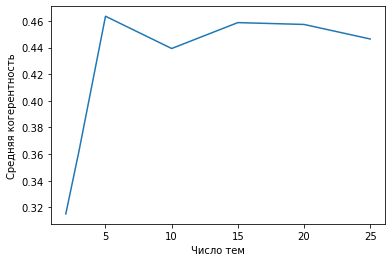

In [83]:
topics_list = [2, 3, 5, 10, 15, 20, 25]
coherences = []

for num in tqdm(topics_list):
    lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=num, chunksize=50, update_every=1, passes=2)
    coherences.append(CoherenceModel(model=lda, texts=data['text'], dictionary=dictionary, coherence='c_v').get_coherence())

plt.plot(topics_list, coherences)
plt.xlabel("Число тем")
plt.ylabel("Средняя когерентность")
plt.show()

In [84]:
lda_15 = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=5, chunksize=50, update_every=1, passes=2)
vis_data = gensimvis.prepare(lda_15, corpus, dictionary)
pyLDAvis.display(vis_data)

/Users/anna/miniforge3/envs/tf_m1/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
